<a href="https://colab.research.google.com/github/AlexCergeev/Analog-of-AlphaZero/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%B0%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Start on GPU (Runtime shape High-RAM)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Chess/chessData.csv.zip

Archive:  /content/drive/MyDrive/Chess/chessData.csv.zip
  inflating: chessData.csv           


# Import required libraries

You need to upload 3 files: 

1.   data.pgn
2.   stockfish.csv
3.   stockfish_13_linux_x64_bmi2.zim



In [1]:
!pip install python-chess==0.31.3

In [2]:
import chess
import chess.engine
import chess.pgn
import random
from PIL import Image, ImageFilter
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import time
import csv

In [3]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization,\
                                    Input
import tensorflow.keras.callbacks as callbacks

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import sys

# GPU Optimization

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Functions

In [6]:
# this function will create our f(x) (score)
def stockfish(board):
  with chess.engine.SimpleEngine.popen_uci('/content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2') as sf:
    for i in range(19, 0, -1):    
      result = sf.analyse(board, chess.engine.Limit(depth=i))
      score = result['score'].white().score()
      if score is not None: break
    return score

In [7]:
board = chess.Board()

In [8]:
BOARD_SIZE = (8, 8, 6)
PIECE_TO_INDEX = {'P' : 0, 'R' : 1, 'N' : 2, 'B' : 3, 'Q' : 4, 'K' : 5}
INDEX_TO_PIECE = {0 : 'P', 1 : 'R', 2 : 'N', 3 : 'B', 4 : 'Q', 5 : 'K'}
Y_TO_CHESSY = {0 : 'a', 1 : 'b', 2 : 'c', 3 : 'd', 4 : 'e', 5 : 'f', 6 : 'g', 7 : 'h'}
CHESSY_TO_Y = {'a' : 0, 'b' : 1, 'c' : 2, 'd' : 3, 'e' : 4, 'f' : 5, 'g' : 6, 'h' : 7}

In [9]:
def convert_bitboard_to_image(board):
	im2d = np.array(list(board.split()[0].replace('/', '').replace('8', '.'*8).replace('7', '.'*7).replace('6', '.'*6).replace('5', '.'*5).replace('4', '.'*4).replace('3', '.'*3).replace('2', '.'*2).replace('1', '.'*1))).reshape((8, 8))
	im = np.array(np.random.rand(8,8,6)/10, dtype=np.float16) #np.zeros(BOARD_SIZE, dtype=np.int8)

	for i in range(BOARD_SIZE[0]):
		for j in range(BOARD_SIZE[1]):
			piece = im2d[i, j]
			if piece == '.': continue
			if piece.isupper():
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = 1
			else:
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = -1
  

	return im

In [10]:
def board_to_image(board):
	im2d = np.array(list(str(board).replace('\n', '').replace(' ', ''))).reshape((8, 8))
	im = np.zeros(BOARD_SIZE)

	for i in range(BOARD_SIZE[0]):
		for j in range(BOARD_SIZE[1]):
			piece = im2d[i, j]
			if piece == '.': continue
			if piece.isupper():
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = 1
			else:
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = -1

	return im

In [11]:
def predict(board):
  board3d = board_to_image(board)
  board3d = np.expand_dims(board3d, 0)
  return model.predict(board3d)[0][0]

**The AI will learn how to give a accurate prediction of *f(x)* when we present a *x* never seen before.**

*board -> score*

# Creating the dataset

In [12]:
y_train = []
x_train = []

with open('/content/chessData.csv', newline='') as File:  
    reader = csv.reader(File)
    for step, row in enumerate(reader):
        if row == ['FEN', 'Evaluation']:
          continue 
        fen, stfish = row[0], row[1]

        if stfish[0]=='#': continue

        x_train.append(convert_bitboard_to_image(fen))

        # if stfish[0]=='#':
        #   stfish = stfish.replace('#', '')
        
        y_train.append(float(stfish.replace("\ufeff", ""))/100)

        if step % 2000000 == 0:  print("step =",step)
        if step > 8000000: break  #Max 10 000 000

x_train = np.array(x_train)
y_train = np.array(y_train)

mean = np.mean(y_train)
std = np.std(y_train)
y_train = np.asarray((y_train-mean)/ (std*3), dtype=np.float32)
#y_train = np.asarray(y_train / abs(y_train).max() / 2 + 0.5, dtype=np.float32)
print(x_train.shape)
print(y_train.shape)

step = 4000000
step = 6000000
step = 8000000
(7899505, 8, 8, 6)
(7899505,)


Now we need to convert the board representation to something meaningful.

A 3d matrix of sizes **8 x 8 x 6**



In [ ]:
def get_dataset():
	container = np.load('/content/drive/MyDrive/Chess/file_without_mat.npz')
	b, v = container['arr_0'], container['arr_1']
	# normalization (0 - 1)
	return b, v

x_train, y_train = get_dataset()

mean = np.mean(y_train)
std = np.std(y_train)
y_train = np.asarray((y_train-mean)/ (std*3), dtype=np.float32)

print(x_train.shape)
print(y_train.shape)

(12767881, 8, 8, 6)
(12767881,)


In [13]:
samples = y_train.shape[0] - 200000  # 1981517

# Reserve 10,000 samples for validation.
x_val = x_train[samples:]
y_val = y_train[samples:]
x_train_final = x_train[:samples]
y_train_final = y_train[:samples]

# Model


https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [14]:
def build_model(depth):
  board3d = layers.Input(shape=(8, 8,6))

  # adding the convolutional layers
  x = board3d
  x = layers.Conv2D(6, kernel_size=(3,3), padding='same', activation="softsign")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(depth, activation="softsign")(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(depth, activation="softsign")(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation="softsign")(x)
  return models.Model(inputs=board3d, outputs=x)


#model = build_model(80)
#model.summary()

# It's training time!

In [ ]:
model = build_model(80)
model.compile(optimizer=optimizers.Adam(learning_rate=0.00005), loss='mean_squared_error')
model.summary()
history = model.fit(x_train_final, y_train_final,   # TODO x_train, y_train change to ai traing 
            batch_size=1000,
            epochs=150,
            validation_data =(x_val, y_val),
            verbose=1)#,
              #callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
              #         callbacks.EarlyStopping(monitor='loss', patience=15)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 6)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 6)           330       
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                30800     
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0     

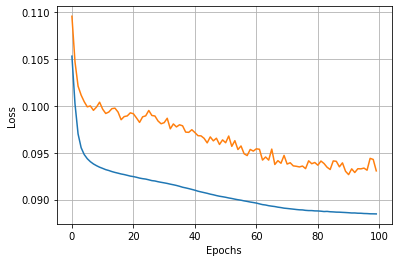

In [18]:
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.plot(history.epoch, history.history["loss"],  label='loss')
plt.grid()
plt.plot(history.epoch, history.history["val_loss"],  label='val_loss' )
plt.show()

# Gradients

In [ ]:
# Instantiate an optimizer.
optimizer = optimizers.Adam()
# Instantiate a loss function.
loss_fn = tf.compat.v1.losses.mean_squared_error

EPOCHS = 1
#model = build_model_residual(8,4)
model = build_model(384)
BS = 51200
numUpdates = int(y_train.shape[0] / BS)
history_grad = []
sum_history = []

for epoch in range(0, EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    for i in range(0, numUpdates):
              with tf.GradientTape() as tape:
                start = i * BS
                end = start + BS
                logits = model(x_train_final[start:end], training=True)  # Logits for this minibatch
                
                # Compute the loss value for this minibatch.
                loss_value = tf.keras.losses.MSE(y_train_final[start:end], logits)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                #sum_history.append(np.average(grads))
                for layers_grads in grads:
                  sum_history.append(np.average(layers_grads))
                history_grad.append(sum_history)
                if start > samples:
                  break

                # Log every 200 batches.
                #if i % 400 == 0:
                    #print("Training loss (for one batch) at step %d: %.4f"% (start, float(loss_value)))
                    #print("Seen so far: %s samples" % ((start + 1) * batch_size))



In [ ]:
b=0
for st, i in enumerate(grads):
  #print(i.shape)
  b = st+1
  #if  st > 100:break
#print(b)

layer_all = []
num = b
for i in range(0,b):
  layer = []
  for s, layers_grads in enumerate(history_grad[0]):
    if ((s+1)%num == i):
      layer.append(layers_grads)
    #print("layer",(s+1)%num,',', layers_grads)
    #if s > 1000: break

  layer_all.append(layer)

In [ ]:
for i in layer_all:
  plt.plot(i)
  plt.xlabel("layer")
  plt.xlabel("butch")
  plt.grid()
  plt.show()
 

# Playing with the AI

In [ ]:
!unzip /content/stockfish_13_linux_x64_bmi2.zip
!chmod +x /content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2

In [44]:
# Get move from model
def get_move(board):
  h = []
  move_answer = []
  start = predict(board)
  for move in board.legal_moves:
      board.push(move)
      h.append(abs(start - predict(board)))
      move_answer.append(move)
      #print(move,abs(start - predict(board)))
      board.pop()
  #print(move_answer[h.index(min(h))])
  #print(move_answer[h.index(max(h))])
  return move_answer[h.index(min(h))]

In [ ]:
# Get move from stockfish
start_fish = (stockfish(board)+50)/100
h = []
move_answer = []
for move in board.legal_moves:
    board.push(move)
    h.append(start_fish - (stockfish(board)+50)/100)
    move_answer.append(move)
    #print(move,abs(start_fish - (stockfish(board)+50)/100))
    board.pop()
print(move_answer[h.index(min(h))])

In [ ]:
board.push(get_move(board))
board

In [ ]:
board.push_uci('b2a3')
board

In [ ]:
board.pop()

In [ ]:
board

In [ ]:
get_move(board)

Move.from_uci('g2g3')